# Build a Customer Support Bot - Zero-shot Agent ( Adding conditional human feedback )

# 1. Install Dependencies

In [12]:
%%capture --no-stderr
%pip install -U langgraph langchain-community langchain-openai tavily-python pandas openai

In [2]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")

OPENAI_API_KEY: ··········
TAVILY_API_KEY: ··········


# 2. Populate the Database

1. Database Download and Backup:

db_url = "https://storage.googleapis.com/benchmarks-artifacts/travel-db/travel2.sqlite": Defines the URL of the SQLite database.

local_file = "travel2.sqlite": Sets the local filename for the downloaded database.

backup_file = "travel2.backup.sqlite": Sets the filename for the backup copy.

overwrite = False: A flag to control whether to overwrite the existing database.

if overwrite or not os.path.exists(local_file):: Checks if the database should be downloaded (if overwrite is True or the file doesn't exist).

response = requests.get(db_url): Downloads the database from the URL using the requests library.

response.raise_for_status(): Checks if the download was successful (raises an exception if not).

with open(local_file, "wb") as f: f.write(response.content): Writes the downloaded content to the local file.

shutil.copy(local_file, backup_file): Creates a backup copy of the downloaded database.

2. update_dates Function:

def update_dates(file):: Defines a function to update the dates in the database.

shutil.copy(backup_file, file): Copies the backup to the working file, effectively resetting the database to its original state.

conn = sqlite3.connect(file): Establishes a connection to the SQLite database.
cursor = conn.cursor(): Creates a cursor object to execute SQL commands.

tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn).name.tolist(): Retrieves a list of table names from the database.

tdf = {}: Initializes a dictionary to store Pandas DataFrames for each table.
for t in tables: tdf[t] = pd.read_sql(f"SELECT * from {t}", conn): Reads each table into a Pandas DataFrame and stores it in the tdf dictionary.

example_time = pd.to_datetime(tdf["flights"]["actual_departure"].replace("\\N", pd.NaT)).max(): Finds the latest actual_departure time in the flights table.
current_time = pd.to_datetime("now").tz_localize(example_time.tz): Gets the current time, localized to the timezone of the example_time.

time_diff = current_time - example_time: Calculates the time difference between the current time and the latest departure time.

tdf["bookings"]["book_date"] = pd.to_datetime(tdf["bookings"]["book_date"].replace("\\N", pd.NaT), utc=True) + time_diff: Updates the book_date column in the bookings table by adding the time_diff.

datetime_columns = ["scheduled_departure", "scheduled_arrival", "actual_departure", "actual_arrival"]: Defines a list of datetime columns in the flights table.

for column in datetime_columns: tdf["flights"][column] = pd.to_datetime(tdf["flights"][column].replace("\\N", pd.NaT)) + time_diff: Updates the datetime columns in the flights table by adding the time_diff.

for table_name, df in tdf.items(): df.to_sql(table_name, conn, if_exists="replace", index=False): Writes the updated DataFrames back to the database, replacing the existing tables.

conn.commit(): Commits the changes to the database.

conn.close(): Closes the database connection.

return file: returns the file that was updated.

3. Database Update:

db = update_dates(local_file): Calls the update_dates function to update the dates in the local database file.

Summary

This code downloads a travel database, creates a backup, and then adjusts the date and time information within the database to make it appear as if the events happened recently.

In [3]:
import os
import shutil
import sqlite3

import pandas as pd
import requests

db_url = "https://storage.googleapis.com/benchmarks-artifacts/travel-db/travel2.sqlite"
local_file = "travel2.sqlite"
# The backup lets us restart for each tutorial section
backup_file = "travel2.backup.sqlite"
overwrite = False
if overwrite or not os.path.exists(local_file):
    response = requests.get(db_url)
    response.raise_for_status()  # Ensure the request was successful
    with open(local_file, "wb") as f:
        f.write(response.content)
    # Backup - we will use this to "reset" our DB in each section
    shutil.copy(local_file, backup_file)


# Convert the flights to present time for our tutorial
def update_dates(file):
    shutil.copy(backup_file, file)
    conn = sqlite3.connect(file)
    cursor = conn.cursor()

    tables = pd.read_sql(
        "SELECT name FROM sqlite_master WHERE type='table';", conn
    ).name.tolist()
    tdf = {}
    for t in tables:
        tdf[t] = pd.read_sql(f"SELECT * from {t}", conn)

    example_time = pd.to_datetime(
        tdf["flights"]["actual_departure"].replace("\\N", pd.NaT)
    ).max()
    current_time = pd.to_datetime("now").tz_localize(example_time.tz)
    time_diff = current_time - example_time

    tdf["bookings"]["book_date"] = (
        pd.to_datetime(tdf["bookings"]["book_date"].replace("\\N", pd.NaT), utc=True)
        + time_diff
    )

    datetime_columns = [
        "scheduled_departure",
        "scheduled_arrival",
        "actual_departure",
        "actual_arrival",
    ]
    for column in datetime_columns:
        tdf["flights"][column] = (
            pd.to_datetime(tdf["flights"][column].replace("\\N", pd.NaT)) + time_diff
        )

    for table_name, df in tdf.items():
        df.to_sql(table_name, conn, if_exists="replace", index=False)
    del df
    del tdf
    conn.commit()
    conn.close()

    return file


db = update_dates(local_file)

### Visualize the database

1. Import necessary dependencies

2. Database Connection:

db_path = 'travel2.sqlite': Defines the path to the SQLite database file.

try: conn = sqlite3.connect(db_path): Attempts to establish a connection to the SQLite database at the specified path. If successful, a connection object (conn) is created.

cursor = conn.cursor(): Creates a cursor object (cursor) from the connection. The cursor is used to execute SQL queries.

3. Table Listing:

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';"): Executes an SQL query to retrieve the names of all tables in the database. The sqlite_master table is a special table that stores metadata about the database.
table_names = [row[0] for row in cursor.fetchall()]: Fetches all the results from the query (table names) and stores them in a list called table_names.

print("Tables in the database:"): Prints a header indicating the start of the table list.

for table_name in table_names: print(f"- {table_name}"): Iterates through the table_names list and prints each table name.

4. Table Data Display:

df = pd.read_sql_query(f"SELECT * FROM {table_name} LIMIT 5", conn): For each table, this line executes an SQL query to select all columns (*) from the table, but limits the results to the first 5 rows (LIMIT 5). The results are loaded into a Pandas DataFrame (df).

print(f" First 5 rows of {table_name}:"): Prints a header indicating the first 5 rows of the current table.

print(df): Prints the Pandas DataFrame, displaying the first 5 rows of the table in a tabular format.

print("-" * 20): Prints a separator line to visually separate the output for different tables.

5. Database Closure:

conn.close(): Closes the database connection, releasing any resources held by the connection.

6. Error Handling:

except sqlite3.Error as e: print(f"An error occurred: {e}"): If any sqlite3.Error occurs during the database operations, this block catches the exception and prints an error message.
In essence:

This code provides a way to inspect the structure and contents of a SQLite database. It lists the tables and then displays a preview of the data in each table, making it useful for quickly understanding the database's schema and data.

In [38]:
import sqlite3
import pandas as pd

# Replace 'your_database.sqlite' with the actual filename
db_path = 'travel2.sqlite'

try:
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Get a list of table names
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    table_names = [row[0] for row in cursor.fetchall()]

    print("Tables in the database:")
    for table_name in table_names:
        print(f"- {table_name}")

        # Show the first few rows of each table
        df = pd.read_sql_query(f"SELECT * FROM {table_name} LIMIT 5", conn)
        print(f"  First 5 rows of {table_name}:")
        print(df)
        print("-" * 20)

    conn.close()

except sqlite3.Error as e:
    print(f"An error occurred: {e}")

Tables in the database:
- aircrafts_data
  First 5 rows of aircrafts_data:
  aircraft_code                model  range
0           773       Boeing 777-300  11100
1           763       Boeing 767-300   7900
2           SU9  Sukhoi Superjet-100   3000
3           320      Airbus A320-200   5700
4           321      Airbus A321-200   5600
--------------------
- airports_data
  First 5 rows of airports_data:
  airport_code                                      airport_name         city  \
0          ATL  Hartsfield-Jackson Atlanta International Airport      Atlanta   
1          PEK             Beijing Capital International Airport      Beijing   
2          DXB                       Dubai International Airport        Dubai   
3          LAX                 Los Angeles International Airport  Los Angeles   
4          HND                              Tokyo Haneda Airport        Tokyo   

            coordinates             timezone  
0   [33.6407, -84.4277]     America/New_York  
1   [40.07

# 3. Define the tools

Next, define our assistant's tools to search the airline's policy manual and search and manage reservations for flights, hotels, car rentals, and excursions.

## Tool 1 - Feeding the Company Policy Manual

1. Import necessary dependencies

2. FAQ Document Download and Splitting:

response = requests.get("https://storage.googleapis.com/benchmarks-artifacts/travel-db/swiss_faq.md"): Downloads the FAQ document from the provided URL.

response.raise_for_status(): Checks if the download was successful.

faq_text = response.text: Stores the text content of the FAQ document.

docs = [{"page_content": txt} for txt in re.split(r"(?=\n##)", faq_text)]: Splits the FAQ text into individual documents based on Markdown headings (starting with ##). Each document is stored as a dictionary with a page_content key.

3. VectorStoreRetriever Class:

This class implements a simple in-memory vector store and retriever.

__init__(self, docs: list, vectors: list, oai_client): Initializes the retriever with documents, their vector embeddings, and an OpenAI client.

self._arr: Stores the vector embeddings as a NumPy array.

self._docs: Stores the documents.

self._client: Stores the OpenAI client.

@classmethod from_docs(cls, docs, oai_client): A class method to create a retriever from a list of documents.

It generates embeddings for the documents using the OpenAI text-embedding-3-small model.

It creates and returns a VectorStoreRetriever instance.

query(self, query: str, k: int = 5) -> list[dict]: Performs a similarity search for a given query.

It generates an embedding for the query.

It calculates the cosine similarity between the query embedding and the document embeddings using matrix multiplication (@).

It finds the top k most similar documents using np.argpartition and np.argsort.

It returns a list of dictionaries, where each dictionary contains the document content and its similarity score.

4. retriever Instance:

retriever = VectorStoreRetriever.from_docs(docs, openai.Client()): Creates a VectorStoreRetriever instance from the FAQ documents and the OpenAI client.

5. lookup_policy Tool:

@tool def lookup_policy(query: str) -> str:: Defines a tool named lookup_policy.
query: str: Takes a query string as input.

"""Consult the company policies...""": Provides a docstring describing the tool's purpose.

docs = retriever.query(query, k=2): Performs a similarity search using the retriever to find the top 2 most relevant documents.

return "\n\n".join([doc["page_content"] for doc in docs]): Joins the content of the retrieved documents with double newlines and returns the result.

In essence:

This code sets up a simple retrieval system for FAQ documents using OpenAI embeddings and NumPy for similarity search. It then defines a tool that uses this retrieval system to look up company policies based on a user's query. This tool can be used within a LangChain application to provide policy information to a language model or other components.

In [4]:
import re

import numpy as np
import openai
from langchain_core.tools import tool

response = requests.get(
    "https://storage.googleapis.com/benchmarks-artifacts/travel-db/swiss_faq.md"
)
response.raise_for_status()
faq_text = response.text

docs = [{"page_content": txt} for txt in re.split(r"(?=\n##)", faq_text)]


class VectorStoreRetriever:
    def __init__(self, docs: list, vectors: list, oai_client):
        self._arr = np.array(vectors)
        self._docs = docs
        self._client = oai_client

    @classmethod
    def from_docs(cls, docs, oai_client):
        embeddings = oai_client.embeddings.create(
            model="text-embedding-3-small", input=[doc["page_content"] for doc in docs]
        )
        vectors = [emb.embedding for emb in embeddings.data]
        return cls(docs, vectors, oai_client)

    def query(self, query: str, k: int = 5) -> list[dict]:
        embed = self._client.embeddings.create(
            model="text-embedding-3-small", input=[query]
        )
        # "@" is just a matrix multiplication in python
        scores = np.array(embed.data[0].embedding) @ self._arr.T
        top_k_idx = np.argpartition(scores, -k)[-k:]
        top_k_idx_sorted = top_k_idx[np.argsort(-scores[top_k_idx])]
        return [
            {**self._docs[idx], "similarity": scores[idx]} for idx in top_k_idx_sorted
        ]


retriever = VectorStoreRetriever.from_docs(docs, openai.Client())


@tool
def lookup_policy(query: str) -> str:
    """Consult the company policies to check whether certain options are permitted.
    Use this before making any flight changes performing other 'write' events."""
    docs = retriever.query(query, k=2)
    return "\n\n".join([doc["page_content"] for doc in docs])

## Toolset 2 -  fetch and manipulate flight and ticket information

1. fetch_user_flight_information Tool:

Purpose: Retrieves all flight and ticket details for a specific passenger.

Input:

config: RunnableConfig: LangChain configuration object, which should contain the passenger_id in the configurable dictionary.

Logic:

Extracts the passenger_id from the config.

Connects to the SQLite database.

Executes an SQL query that joins the tickets, ticket_flights, flights, and boarding_passes tables to retrieve the necessary information.

Fetches the results and converts them into a list of dictionaries, where each dictionary represents a row.

Closes the database connection.

Returns the list of dictionaries.

SQL Query:

Joins multiple tables to get ticket, flight, and seat information.
Filters results based on the provided passenger_id.

2. search_flights Tool:

Purpose: Searches for flights based on specified criteria.

Input:

departure_airport: Optional[str]: Departure airport code (optional).

arrival_airport: Optional[str]: Arrival airport code (optional).

start_time: Optional[date | datetime]: Start of the departure time range (optional).

end_time: Optional[date | datetime]: End of the departure time range (optional).

limit: int: Maximum number of results to return.

Logic:

Connects to the database.

Constructs an SQL query dynamically based on the provided input parameters.

Executes the query and fetches the results.

Converts the results into a list of dictionaries.

Closes the database connection.

Returns the list of dictionaries.

SQL Query:

Starts with a base query (SELECT * FROM flights WHERE 1 = 1).

Adds AND clauses to the query based on the provided input parameters.

Uses parameterized queries to prevent SQL injection.

Applies a LIMIT clause to restrict the number of results.

3. update_ticket_to_new_flight Tool:

Purpose: Updates a ticket to a new flight.

Input:

ticket_no: str: Ticket number.

new_flight_id: int: ID of the new flight.

config: RunnableConfig: Configuration object containing the passenger_id.

Logic:

Extracts the passenger_id from the config.

Connects to the database.

Validates the new_flight_id and checks if the passenger owns the ticket.

Checks that the new flight departs more than 3 hours from the current time.

Updates the ticket_flights table with the new flight ID.

Commits the changes and closes the connection.

Returns a success or error message.

Important Checks:

Validates the new flight ID.

Checks if the ticket exists.

Verifies that the passenger owns the ticket.

Enforces a 3-hour minimum time difference for rescheduling.

4. cancel_ticket Tool:

Purpose: Cancels a ticket.

Input:

ticket_no: str: Ticket number.

config: RunnableConfig: Configuration object containing the passenger_id.

Logic:

Extracts the passenger_id from the config.

Connects to the database.

Validates the ticket and verifies that the passenger owns it.

Deletes the ticket from the ticket_flights table.

Commits the changes and closes the connection.

Returns a success or error message.

Important Checks:

Checks if the ticket exists.

Verifies that the passenger owns the ticket.

Summary

These tools provide a set of operations that can be used within a LangChain application to interact with a travel database, allowing for tasks such as retrieving flight information, searching for flights, updating tickets, and canceling tickets.

In [5]:
import sqlite3
from datetime import date, datetime
from typing import Optional

import pytz
from langchain_core.runnables import RunnableConfig


@tool
def fetch_user_flight_information(config: RunnableConfig) -> list[dict]:
    """Fetch all tickets for the user along with corresponding flight information and seat assignments.

    Returns:
        A list of dictionaries where each dictionary contains the ticket details,
        associated flight details, and the seat assignments for each ticket belonging to the user.
    """
    configuration = config.get("configurable", {})
    passenger_id = configuration.get("passenger_id", None)
    if not passenger_id:
        raise ValueError("No passenger ID configured.")

    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = """
    SELECT
        t.ticket_no, t.book_ref,
        f.flight_id, f.flight_no, f.departure_airport, f.arrival_airport, f.scheduled_departure, f.scheduled_arrival,
        bp.seat_no, tf.fare_conditions
    FROM
        tickets t
        JOIN ticket_flights tf ON t.ticket_no = tf.ticket_no
        JOIN flights f ON tf.flight_id = f.flight_id
        JOIN boarding_passes bp ON bp.ticket_no = t.ticket_no AND bp.flight_id = f.flight_id
    WHERE
        t.passenger_id = ?
    """
    cursor.execute(query, (passenger_id,))
    rows = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]

    cursor.close()
    conn.close()

    return results


@tool
def search_flights(
    departure_airport: Optional[str] = None,
    arrival_airport: Optional[str] = None,
    start_time: Optional[date | datetime] = None,
    end_time: Optional[date | datetime] = None,
    limit: int = 20,
) -> list[dict]:
    """Search for flights based on departure airport, arrival airport, and departure time range."""
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM flights WHERE 1 = 1"
    params = []

    if departure_airport:
        query += " AND departure_airport = ?"
        params.append(departure_airport)

    if arrival_airport:
        query += " AND arrival_airport = ?"
        params.append(arrival_airport)

    if start_time:
        query += " AND scheduled_departure >= ?"
        params.append(start_time)

    if end_time:
        query += " AND scheduled_departure <= ?"
        params.append(end_time)
    query += " LIMIT ?"
    params.append(limit)
    cursor.execute(query, params)
    rows = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]

    cursor.close()
    conn.close()

    return results


@tool
def update_ticket_to_new_flight(
    ticket_no: str, new_flight_id: int, *, config: RunnableConfig
) -> str:
    """Update the user's ticket to a new valid flight."""
    configuration = config.get("configurable", {})
    passenger_id = configuration.get("passenger_id", None)
    if not passenger_id:
        raise ValueError("No passenger ID configured.")

    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "SELECT departure_airport, arrival_airport, scheduled_departure FROM flights WHERE flight_id = ?",
        (new_flight_id,),
    )
    new_flight = cursor.fetchone()
    if not new_flight:
        cursor.close()
        conn.close()
        return "Invalid new flight ID provided."
    column_names = [column[0] for column in cursor.description]
    new_flight_dict = dict(zip(column_names, new_flight))
    timezone = pytz.timezone("Etc/GMT-3")
    current_time = datetime.now(tz=timezone)
    departure_time = datetime.strptime(
        new_flight_dict["scheduled_departure"], "%Y-%m-%d %H:%M:%S.%f%z"
    )
    time_until = (departure_time - current_time).total_seconds()
    if time_until < (3 * 3600):
        return f"Not permitted to reschedule to a flight that is less than 3 hours from the current time. Selected flight is at {departure_time}."

    cursor.execute(
        "SELECT flight_id FROM ticket_flights WHERE ticket_no = ?", (ticket_no,)
    )
    current_flight = cursor.fetchone()
    if not current_flight:
        cursor.close()
        conn.close()
        return "No existing ticket found for the given ticket number."

    # Check the signed-in user actually has this ticket
    cursor.execute(
        "SELECT * FROM tickets WHERE ticket_no = ? AND passenger_id = ?",
        (ticket_no, passenger_id),
    )
    current_ticket = cursor.fetchone()
    if not current_ticket:
        cursor.close()
        conn.close()
        return f"Current signed-in passenger with ID {passenger_id} not the owner of ticket {ticket_no}"

    # In a real application, you'd likely add additional checks here to enforce business logic,
    # like "does the new departure airport match the current ticket", etc.
    # While it's best to try to be *proactive* in 'type-hinting' policies to the LLM
    # it's inevitably going to get things wrong, so you **also** need to ensure your
    # API enforces valid behavior
    cursor.execute(
        "UPDATE ticket_flights SET flight_id = ? WHERE ticket_no = ?",
        (new_flight_id, ticket_no),
    )
    conn.commit()

    cursor.close()
    conn.close()
    return "Ticket successfully updated to new flight."


@tool
def cancel_ticket(ticket_no: str, *, config: RunnableConfig) -> str:
    """Cancel the user's ticket and remove it from the database."""
    configuration = config.get("configurable", {})
    passenger_id = configuration.get("passenger_id", None)
    if not passenger_id:
        raise ValueError("No passenger ID configured.")
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "SELECT flight_id FROM ticket_flights WHERE ticket_no = ?", (ticket_no,)
    )
    existing_ticket = cursor.fetchone()
    if not existing_ticket:
        cursor.close()
        conn.close()
        return "No existing ticket found for the given ticket number."

    # Check the signed-in user actually has this ticket
    cursor.execute(
        "SELECT ticket_no FROM tickets WHERE ticket_no = ? AND passenger_id = ?",
        (ticket_no, passenger_id),
    )
    current_ticket = cursor.fetchone()
    if not current_ticket:
        cursor.close()
        conn.close()
        return f"Current signed-in passenger with ID {passenger_id} not the owner of ticket {ticket_no}"

    cursor.execute("DELETE FROM ticket_flights WHERE ticket_no = ?", (ticket_no,))
    conn.commit()

    cursor.close()
    conn.close()
    return "Ticket successfully cancelled."

## Toolset 3 - Car rental tools

1. search_car_rentals Tool:

Purpose: Searches for car rentals based on various criteria.

Input:

location: Optional[str]: Location of the rental.

name: Optional[str]: Name of the rental company.

price_tier: Optional[str]: Price tier.

start_date: Optional[Union[datetime, date]]: Start date.

end_date: Optional[Union[datetime, date]]: End date.

Logic:

Connects to the SQLite database.

Constructs a dynamic SQL query based on the provided input parameters.

Uses LIKE operator to allow for partial string matching for location and name.

Executes the query and fetches the results.

Converts the results into a list of dictionaries.

Closes the database connection.

Returns the list of car rental dictionaries.

SQL Query:

Starts with SELECT * FROM car_rentals WHERE 1=1.
Adds AND clauses for each provided input parameter.
Uses LIKE operator with % wildcards for string matching.

2. book_car_rental Tool:

Purpose: Books a car rental by its ID.

Input:

rental_id: int: ID of the rental to book.

Logic:

Connects to the database.

Executes an UPDATE query to set the booked column to 1 for the specified rental_id.

Commits the changes.

Checks cursor.rowcount to determine if any rows were affected.

Closes the database connection.

Returns a success or error message.

3. update_car_rental Tool:

Purpose: Updates the start and end dates of a car rental.

Input:

rental_id: int: ID of the rental to update.

start_date: Optional[Union[datetime, date]]: New start date.

end_date: Optional[Union[datetime, date]]: New end date.

Logic:

Connects to the database.

Executes UPDATE queries to update the start_date and/or end_date columns.

Commits the changes.

Checks cursor.rowcount to determine if any rows were affected.

Closes the database connection.

Returns a success or error message.

4. cancel_car_rental Tool:

Purpose: Cancels a car rental by its ID.

Input:

rental_id: int: ID of the rental to cancel.

Logic:

Connects to the database.

Executes an UPDATE query to set the booked column to 0 for the specified rental_id.

Commits the changes.

Checks cursor.rowcount to determine if any rows were affected.

Closes the database connection.

Returns a success or error message.

These tools provide a set of operations that can be used within a LangChain application to manage car rentals, allowing for tasks such as searching, booking, updating, and canceling rentals.

In [6]:
from datetime import date, datetime
from typing import Optional, Union


@tool
def search_car_rentals(
    location: Optional[str] = None,
    name: Optional[str] = None,
    price_tier: Optional[str] = None,
    start_date: Optional[Union[datetime, date]] = None,
    end_date: Optional[Union[datetime, date]] = None,
) -> list[dict]:
    """
    Search for car rentals based on location, name, price tier, start date, and end date.

    Args:
        location (Optional[str]): The location of the car rental. Defaults to None.
        name (Optional[str]): The name of the car rental company. Defaults to None.
        price_tier (Optional[str]): The price tier of the car rental. Defaults to None.
        start_date (Optional[Union[datetime, date]]): The start date of the car rental. Defaults to None.
        end_date (Optional[Union[datetime, date]]): The end date of the car rental. Defaults to None.

    Returns:
        list[dict]: A list of car rental dictionaries matching the search criteria.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM car_rentals WHERE 1=1"
    params = []

    if location:
        query += " AND location LIKE ?"
        params.append(f"%{location}%")
    if name:
        query += " AND name LIKE ?"
        params.append(f"%{name}%")
    # For our tutorial, we will let you match on any dates and price tier.
    # (since our toy dataset doesn't have much data)
    cursor.execute(query, params)
    results = cursor.fetchall()

    conn.close()

    return [
        dict(zip([column[0] for column in cursor.description], row)) for row in results
    ]


@tool
def book_car_rental(rental_id: int) -> str:
    """
    Book a car rental by its ID.

    Args:
        rental_id (int): The ID of the car rental to book.

    Returns:
        str: A message indicating whether the car rental was successfully booked or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE car_rentals SET booked = 1 WHERE id = ?", (rental_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Car rental {rental_id} successfully booked."
    else:
        conn.close()
        return f"No car rental found with ID {rental_id}."


@tool
def update_car_rental(
    rental_id: int,
    start_date: Optional[Union[datetime, date]] = None,
    end_date: Optional[Union[datetime, date]] = None,
) -> str:
    """
    Update a car rental's start and end dates by its ID.

    Args:
        rental_id (int): The ID of the car rental to update.
        start_date (Optional[Union[datetime, date]]): The new start date of the car rental. Defaults to None.
        end_date (Optional[Union[datetime, date]]): The new end date of the car rental. Defaults to None.

    Returns:
        str: A message indicating whether the car rental was successfully updated or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    if start_date:
        cursor.execute(
            "UPDATE car_rentals SET start_date = ? WHERE id = ?",
            (start_date, rental_id),
        )
    if end_date:
        cursor.execute(
            "UPDATE car_rentals SET end_date = ? WHERE id = ?", (end_date, rental_id)
        )

    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Car rental {rental_id} successfully updated."
    else:
        conn.close()
        return f"No car rental found with ID {rental_id}."


@tool
def cancel_car_rental(rental_id: int) -> str:
    """
    Cancel a car rental by its ID.

    Args:
        rental_id (int): The ID of the car rental to cancel.

    Returns:
        str: A message indicating whether the car rental was successfully cancelled or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE car_rentals SET booked = 0 WHERE id = ?", (rental_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Car rental {rental_id} successfully cancelled."
    else:
        conn.close()
        return f"No car rental found with ID {rental_id}."

## Toolset 4 - Hotel booking tools

1. search_hotels Tool:

Purpose: Searches for hotels based on various criteria.

Input:

location: Optional[str]: Location of the hotel.

name: Optional[str]: Name of the hotel.

price_tier: Optional[str]: Price tier of the hotel.

checkin_date: Optional[Union[datetime, date]]: Check-in date.

checkout_date: Optional[Union[datetime, date]]: Check-out date.

Logic:

Connects to the SQLite database.

Constructs a dynamic SQL query based on the provided input parameters.

Uses LIKE operator to allow for partial string matching for location and name.

Executes the query and fetches the results.

Converts the results into a list of dictionaries.

Closes the database connection.

Returns the list of hotel dictionaries.

SQL Query:

Starts with SELECT * FROM hotels WHERE 1=1.

Adds AND clauses for each provided input parameter.

Uses LIKE operator with % wildcards for string matching.

Note: It mentions that for the tutorial, any dates and price tier will match, so it does not actually filter by those parameters.

2. book_hotel Tool:

Purpose: Books a hotel by its ID.

Input:

hotel_id: int: ID of the hotel to book.

Logic:

Connects to the database.

Executes an UPDATE query to set the booked column to 1 for the specified hotel_id.

Commits the changes.

Checks cursor.rowcount to determine if any rows were affected.

Closes the database connection.

Returns a success or error message.

3. update_hotel Tool:

Purpose: Updates the check-in and check-out dates of a hotel.

Input:

hotel_id: int: ID of the hotel to update.

checkin_date: Optional[Union[datetime, date]]: New check-in date.

checkout_date: Optional[Union[datetime, date]]: New check-out date.

Logic:

Connects to the database.

Executes UPDATE queries to update the checkin_date and/or checkout_date columns.
Commits the changes.

Checks cursor.rowcount to determine if any rows were affected.

Closes the database connection.

Returns a success or error message.

4. cancel_hotel Tool:

Purpose: Cancels a hotel reservation by its ID.

Input:

hotel_id: int: ID of the hotel to cancel.

Logic:

Connects to the database.

Executes an UPDATE query to set the booked column to 0 for the specified hotel_id.

Commits the changes.

Checks cursor.rowcount to determine if any rows were affected.

Closes the database connection.

Returns a success or error message.

These tools provide a set of operations that can be used within a LangChain application to manage hotel bookings, allowing for tasks such as searching, booking, updating, and canceling rentals.

In [7]:
@tool
def search_hotels(
    location: Optional[str] = None,
    name: Optional[str] = None,
    price_tier: Optional[str] = None,
    checkin_date: Optional[Union[datetime, date]] = None,
    checkout_date: Optional[Union[datetime, date]] = None,
) -> list[dict]:
    """
    Search for hotels based on location, name, price tier, check-in date, and check-out date.

    Args:
        location (Optional[str]): The location of the hotel. Defaults to None.
        name (Optional[str]): The name of the hotel. Defaults to None.
        price_tier (Optional[str]): The price tier of the hotel. Defaults to None. Examples: Midscale, Upper Midscale, Upscale, Luxury
        checkin_date (Optional[Union[datetime, date]]): The check-in date of the hotel. Defaults to None.
        checkout_date (Optional[Union[datetime, date]]): The check-out date of the hotel. Defaults to None.

    Returns:
        list[dict]: A list of hotel dictionaries matching the search criteria.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM hotels WHERE 1=1"
    params = []

    if location:
        query += " AND location LIKE ?"
        params.append(f"%{location}%")
    if name:
        query += " AND name LIKE ?"
        params.append(f"%{name}%")
    # For the sake of this tutorial, we will let you match on any dates and price tier.
    cursor.execute(query, params)
    results = cursor.fetchall()

    conn.close()

    return [
        dict(zip([column[0] for column in cursor.description], row)) for row in results
    ]


@tool
def book_hotel(hotel_id: int) -> str:
    """
    Book a hotel by its ID.

    Args:
        hotel_id (int): The ID of the hotel to book.

    Returns:
        str: A message indicating whether the hotel was successfully booked or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE hotels SET booked = 1 WHERE id = ?", (hotel_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Hotel {hotel_id} successfully booked."
    else:
        conn.close()
        return f"No hotel found with ID {hotel_id}."


@tool
def update_hotel(
    hotel_id: int,
    checkin_date: Optional[Union[datetime, date]] = None,
    checkout_date: Optional[Union[datetime, date]] = None,
) -> str:
    """
    Update a hotel's check-in and check-out dates by its ID.

    Args:
        hotel_id (int): The ID of the hotel to update.
        checkin_date (Optional[Union[datetime, date]]): The new check-in date of the hotel. Defaults to None.
        checkout_date (Optional[Union[datetime, date]]): The new check-out date of the hotel. Defaults to None.

    Returns:
        str: A message indicating whether the hotel was successfully updated or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    if checkin_date:
        cursor.execute(
            "UPDATE hotels SET checkin_date = ? WHERE id = ?", (checkin_date, hotel_id)
        )
    if checkout_date:
        cursor.execute(
            "UPDATE hotels SET checkout_date = ? WHERE id = ?",
            (checkout_date, hotel_id),
        )

    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Hotel {hotel_id} successfully updated."
    else:
        conn.close()
        return f"No hotel found with ID {hotel_id}."


@tool
def cancel_hotel(hotel_id: int) -> str:
    """
    Cancel a hotel by its ID.

    Args:
        hotel_id (int): The ID of the hotel to cancel.

    Returns:
        str: A message indicating whether the hotel was successfully cancelled or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE hotels SET booked = 0 WHERE id = ?", (hotel_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Hotel {hotel_id} successfully cancelled."
    else:
        conn.close()
        return f"No hotel found with ID {hotel_id}."

## Tool 5 - trip excursion toolset

1. search_trip_recommendations Tool:

Purpose: Searches for trip recommendations based on location, name, and keywords.

Input:

location: Optional[str]: Location of the trip recommendation.

name: Optional[str]: Name of the trip recommendation.

keywords: Optional[str]: Keywords associated with the trip recommendation.

Logic:

Connects to the SQLite database.

Constructs a dynamic SQL query based on the provided input parameters.

Uses LIKE operator to allow for partial string matching for location and name.

Handles keywords:

Splits the keywords string into a list of individual keywords.

Dynamically generates OR conditions for each keyword within the SQL query.

Uses LIKE operator with % wildcards for keyword matching.

Executes the query and fetches the results.

Converts the results into a list of dictionaries.

Closes the database connection.

Returns the list of trip recommendation dictionaries.

SQL Query:

Starts with SELECT * FROM trip_recommendations WHERE 1=1.

Adds AND clauses for each provided input parameter.

Dynamically generates AND and OR clauses for keyword matching.

2. book_excursion Tool:

Purpose: Books an excursion (trip recommendation) by its recommendation ID.

Input:

recommendation_id: int: ID of the trip recommendation to book.

Logic:

Connects to the database.

Executes an UPDATE query to set the booked column to 1 for the specified recommendation_id.

Commits the changes.

Checks cursor.rowcount to determine if any rows were affected.
Closes the database connection.

Returns a success or error message.

3. update_excursion Tool:

Purpose: Updates the details of a trip recommendation.

Input:

recommendation_id: int: ID of the trip recommendation to update.

details: str: New details of the trip recommendation.

Logic:

Connects to the database.

Executes an UPDATE query to set the details column to the provided details for the specified recommendation_id.

Commits the changes.

Checks cursor.rowcount to determine if any rows were affected.
Closes the database connection.

Returns a success or error message.

4. cancel_excursion Tool:

Purpose: Cancels a trip recommendation (excursion) by its recommendation ID.

Input:

recommendation_id: int: ID of the trip recommendation to cancel.

Logic:

Connects to the database.

Executes an UPDATE query to set the booked column to 0 for the specified recommendation_id.

Commits the changes.

Checks cursor.rowcount to determine if any rows were affected.

Closes the database connection.

Returns a success or error message.

These tools provide a set of operations that can be used within a LangChain application to manage excursion bookings, allowing for tasks such as searching, booking, updating, and canceling .

In [8]:
@tool
def search_trip_recommendations(
    location: Optional[str] = None,
    name: Optional[str] = None,
    keywords: Optional[str] = None,
) -> list[dict]:
    """
    Search for trip recommendations based on location, name, and keywords.

    Args:
        location (Optional[str]): The location of the trip recommendation. Defaults to None.
        name (Optional[str]): The name of the trip recommendation. Defaults to None.
        keywords (Optional[str]): The keywords associated with the trip recommendation. Defaults to None.

    Returns:
        list[dict]: A list of trip recommendation dictionaries matching the search criteria.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM trip_recommendations WHERE 1=1"
    params = []

    if location:
        query += " AND location LIKE ?"
        params.append(f"%{location}%")
    if name:
        query += " AND name LIKE ?"
        params.append(f"%{name}%")
    if keywords:
        keyword_list = keywords.split(",")
        keyword_conditions = " OR ".join(["keywords LIKE ?" for _ in keyword_list])
        query += f" AND ({keyword_conditions})"
        params.extend([f"%{keyword.strip()}%" for keyword in keyword_list])

    cursor.execute(query, params)
    results = cursor.fetchall()

    conn.close()

    return [
        dict(zip([column[0] for column in cursor.description], row)) for row in results
    ]


@tool
def book_excursion(recommendation_id: int) -> str:
    """
    Book a excursion by its recommendation ID.

    Args:
        recommendation_id (int): The ID of the trip recommendation to book.

    Returns:
        str: A message indicating whether the trip recommendation was successfully booked or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "UPDATE trip_recommendations SET booked = 1 WHERE id = ?", (recommendation_id,)
    )
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Trip recommendation {recommendation_id} successfully booked."
    else:
        conn.close()
        return f"No trip recommendation found with ID {recommendation_id}."


@tool
def update_excursion(recommendation_id: int, details: str) -> str:
    """
    Update a trip recommendation's details by its ID.

    Args:
        recommendation_id (int): The ID of the trip recommendation to update.
        details (str): The new details of the trip recommendation.

    Returns:
        str: A message indicating whether the trip recommendation was successfully updated or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "UPDATE trip_recommendations SET details = ? WHERE id = ?",
        (details, recommendation_id),
    )
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Trip recommendation {recommendation_id} successfully updated."
    else:
        conn.close()
        return f"No trip recommendation found with ID {recommendation_id}."


@tool
def cancel_excursion(recommendation_id: int) -> str:
    """
    Cancel a trip recommendation by its ID.

    Args:
        recommendation_id (int): The ID of the trip recommendation to cancel.

    Returns:
        str: A message indicating whether the trip recommendation was successfully cancelled or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "UPDATE trip_recommendations SET booked = 0 WHERE id = ?", (recommendation_id,)
    )
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Trip recommendation {recommendation_id} successfully cancelled."
    else:
        conn.close()
        return f"No trip recommendation found with ID {recommendation_id}."

# 4. Define the utility function for handling tool execution and error management

1. Import necessary dependencies

2. handle_tool_error Function:

Purpose: Handles errors that occur during tool execution.

Input:

state: A dictionary representing the current state of the LangGraph.

Logic:

Retrieves the error from the state dictionary using state.get("error").

Retrieves the tool calls from the last message in the state["messages"] list.

Creates a list of ToolMessage objects, where each message:

Contains an error message: f"Error: {repr(error)}\n please fix your mistakes.".

Has the tool_call_id from the corresponding tool call.

Returns a dictionary containing the list of ToolMessage objects, wrapped in a messages key.

Output:

A dictionary with a "messages" key, containing a list of ToolMessage objects describing the error.

3. create_tool_node_with_fallback Function:

Purpose: Creates a ToolNode with fallback error handling.

Input:

tools: A list of tools to be executed by the ToolNode.

Logic:

Creates a ToolNode object with the provided tools.

Adds a fallback handler using with_fallbacks.

The fallback handler is a RunnableLambda that calls the handle_tool_error function.

exception_key="error": Specifies that the error should be stored in the state dictionary under the key "error".

Returns the configured ToolNode.

Output:

A ToolNode object with error handling capabilities.

4. _print_event Function:

Purpose: Prints the contents of a LangGraph event for debugging purposes.

Input:

event: A dictionary representing a LangGraph event.

_printed: A set to keep track of printed message IDs to avoid duplicates.

max_length: The maximum length of the printed message representation.

Logic:

Prints the current dialog state if available.

Retrieves the message from the event.

Checks if the message has already been printed.

If not, it generates a pretty representation of the message using message.pretty_repr(html=True).

Truncates the representation if it exceeds the max_length.

Prints the message representation.

Adds the message ID to the _printed set.

Output:

Prints information about the LangGraph event to the console.

Summary:

handle_tool_error and create_tool_node_with_fallback provide a robust way to handle tool execution errors within a LangGraph, ensuring that the system can gracefully recover from failures.

_print_event is a debugging utility that helps visualize the flow of events and messages within a LangGraph, making it easier to understand and troubleshoot the system's behavior. This is very useful when developing complex LangGraph chains.

In [9]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda

from langgraph.prebuilt import ToolNode


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

# 5. Building the Chatbot using Zero-shot Agent ( With Conditional Interruption )

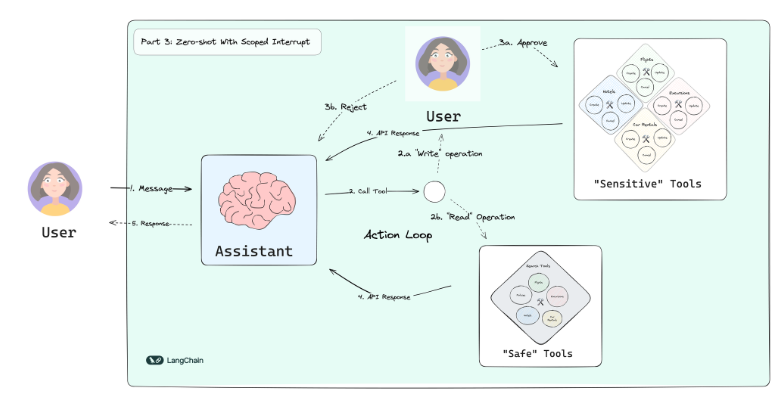

## A. Defining the State and Agent and mapping the safe and sensitive tools

1. Import necessary dependencies

2. State TypedDict:

class State(TypedDict):: Defines a typed dictionary named State to represent the conversation state.

messages: Annotated[list[AnyMessage], add_messages]: Stores a list of messages (user, assistant, tool). The Annotated and add_messages are used to tell LangGraph how to handle the messages.

user_info: str: Stores user-specific information, such as passenger ID.

3. Assistant Class:

class Assistant:: Defines a class to manage the assistant's behavior.

__init__(self, runnable: Runnable): Initializes the assistant with a LangChain Runnable.

__call__(self, state: State, config: RunnableConfig): This method is called when the assistant is invoked.

It enters a while True loop to handle multiple interactions.

result = self.runnable.invoke(state): Invokes the provided runnable with the current state.

Empty Response Handling: Checks if the LLM's response is empty (no tool calls and no content). If it is, it adds a prompt to the messages asking for a real output and updates the state.

If the response is not empty, it breaks the loop.

Returns the LLM's response in a dictionary with the "messages" key.

4. Language Model Initialization:

llm = ChatOpenAI(model="gpt-4o-mini"): Initializes the OpenAI chat model.

Comments indicate that other models are also usable.

5. Assistant Prompt:

assistant_prompt = ChatPromptTemplate.from_messages([...]).partial(time=datetime.now): Creates a prompt for the assistant.

System Prompt: Provides instructions to the assistant:

Role: Customer support for Swiss Airlines.

Use tools to assist users.

Be persistent in searches.

Includes placeholders for user_info and time.

Placeholder: {messages}: Placeholder for the conversation history.

.partial(time=datetime.now): Adds the current time to the prompt.

6. Tools:

safe_tools:

TavilySearchResults: Web search.

fetch_user_flight_information, search_flights, lookup_policy: Flight-related information retrieval.

search_car_rentals, search_hotels, search_trip_recommendations: Search tools.

sensitive_tools:

update_ticket_to_new_flight, cancel_ticket: Flight-related modification tools.

book_car_rental, update_car_rental, cancel_car_rental: Car rental modification tools.

book_hotel, update_hotel, cancel_hotel: Hotel modification tools.

book_excursion, update_excursion, cancel_excursion: Excursion modification tools.

sensitive_tool_names:

Creates a set of the names of the sensitive tools.

7. Assistant Runnable:

part_3_assistant_runnable = assistant_prompt | llm.bind_tools(safe_tools + sensitive_tools): Creates the LangChain runnable by combining the prompt, LLM, and all tools.

Key Concepts:

Safe vs. Sensitive Tools:

The code separates tools into "safe" (read-only) and "sensitive" (modification) categories.

This distinction is crucial for implementing user approval or other control mechanisms over actions that modify user data.

Tool Binding:

llm.bind_tools(safe_tools + sensitive_tools): Binds all tools to the language model, allowing it to use them.

Runnable Setup:

The code sets up a LangChain runnable that combines the prompt, LLM, and tools, ready for execution.

State Management:

The State class is used to hold conversation state.

Summary:

This code sets up a travel assistant with the ability to use a variety of tools. The separation of tools into "safe" and "sensitive" categories is a key feature, as it allows for the implementation of user approval or other control mechanisms for sensitive actions that modify user data. This code is designed to be used with a LangGraph that can utilize the concept of safe and sensitive tools.

In [52]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_info: str


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


# Haiku is faster and cheaper, but less accurate
# llm = ChatAnthropic(model="claude-3-haiku-20240307")
llm = ChatOpenAI(model="gpt-4o-mini")
# You can update the LLMs, though you may need to update the prompts
# from langchain_openai import ChatOpenAI

# llm = ChatOpenAI(model="gpt-4-turbo-preview")

assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant for Swiss Airlines. "
            " Use the provided tools to search for flights, company policies, and other information to assist the user's queries. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\n\nCurrent user:\n<User>\n{user_info}\n</User>"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)


# "Read"-only tools (such as retrievers) don't need a user confirmation to use
safe_tools = [
    TavilySearchResults(max_results=1),
    fetch_user_flight_information,
    search_flights,
    lookup_policy,
    search_car_rentals,
    search_hotels,
    search_trip_recommendations,
]

# These tools all change the user's reservations.
# The user has the right to control what decisions are made
sensitive_tools = [
    update_ticket_to_new_flight,
    cancel_ticket,
    book_car_rental,
    update_car_rental,
    cancel_car_rental,
    book_hotel,
    update_hotel,
    cancel_hotel,
    book_excursion,
    update_excursion,
    cancel_excursion,
]
sensitive_tool_names = {t.name for t in sensitive_tools}
# Our LLM doesn't have to know which nodes it has to route to. In its 'mind', it's just invoking functions.
assistant_runnable = assistant_prompt | llm.bind_tools(
    safe_tools + sensitive_tools
)

## C. Define the Graph and compile

 we split out the tools into 2 separate nodes. We only interrupt before the tools that are actually making changes to the user's bookings.

In [54]:
from typing import Literal

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)


def user_info(state: State):
    return {"user_info": fetch_user_flight_information.invoke({})}


# NEW: The fetch_user_info node runs first, meaning our assistant can see the user's flight information without
# having to take an action
builder.add_node("fetch_user_info", user_info)
builder.add_edge(START, "fetch_user_info")
builder.add_node("assistant", Assistant(assistant_runnable))
builder.add_node("safe_tools", create_tool_node_with_fallback(safe_tools))
builder.add_node(
    "sensitive_tools", create_tool_node_with_fallback(sensitive_tools)
)
# Define logic
builder.add_edge("fetch_user_info", "assistant")


def route_tools(state: State):
    next_node = tools_condition(state)
    # If no tools are invoked, return to the user
    if next_node == END:
        return END
    ai_message = state["messages"][-1]
    # This assumes single tool calls. To handle parallel tool calling, you'd want to
    # use an ANY condition
    first_tool_call = ai_message.tool_calls[0]
    if first_tool_call["name"] in sensitive_tool_names:
        return "sensitive_tools"
    return "safe_tools"


builder.add_conditional_edges(
    "assistant", route_tools, ["safe_tools", "sensitive_tools", END]
)
builder.add_edge("safe_tools", "assistant")
builder.add_edge("sensitive_tools", "assistant")

memory = MemorySaver()
graph = builder.compile(
    checkpointer=memory,
    # NEW: The graph will always halt before executing the "tools" node.
    # The user can approve or reject (or even alter the request) before
    # the assistant continues
    interrupt_before=["sensitive_tools"],
)

## D. Visualize the graph

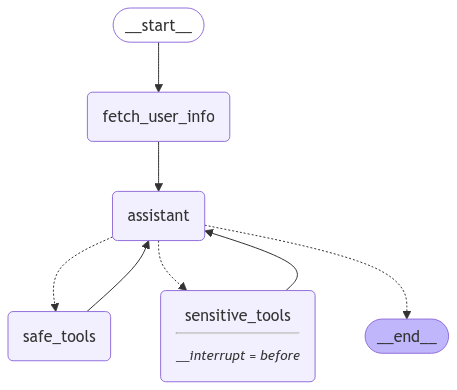

In [55]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## E. Explore the Chatbot with Example conversation

1. Import necessary dependencies

2. Conversation Loop:

for question in tutorial_questions:: Iterates through the tutorial questions.

events = graph.stream({...}, config, stream_mode="values"): Streams the events generated by the LangGraph (graph) for the current question.

for event in events: _print_event(event, _printed): Prints the events to the console.

snapshot = graph.get_state(config): Retrieves the current state of the LangGraph.

while snapshot.next:: This loop handles tool invocations that require user approval.

3. Tool Invocation Approval:

User Input:

user_input = input(...): Prompts the user to approve or deny the tool invocation.

The prompt asks the user to type 'y' to continue or provide an explanation for changes.

Approval:

if user_input.strip() == "y":: If the user types 'y', the code continues the graph execution.

result = graph.invoke(None, config): Invokes the graph with None as input, essentially continuing the execution with the current state.

Denial/Modification:

else:: If the user does not type 'y', the code handles the denial or modification.

result = graph.invoke({...}, config): Invokes the graph with a ToolMessage that informs the assistant about the user's decision.

The ToolMessage contains:

tool_call_id: The ID of the tool call that was denied.

content: A message indicating that the API call was denied and includes the user's reasoning.

This allows the assistant to adjust its behavior based on the user's feedback.

snapshot = graph.get_state(config): Updates the snapshot after each invocation.

Key Concepts:

LangGraph Interaction: The code demonstrates how to interact with a LangGraph, including streaming events and invoking the graph.

Tool Invocation Approval: The core feature is the user approval step, which allows the user to control the actions of the assistant. This is very important when the AI is making changes to user data.

Tool Messages: ToolMessage is used to communicate with the assistant about tool invocations, including denials and modifications.

State Management: The graph.get_state(config) method is used to retrieve the current state of the graph, which is essential for handling tool invocations and user feedback.

User Interaction: The input() function is used to get user input, simulating a real-time interaction.

Error Handling: The try...except block is included to catch potential errors during user input, and if an error occurs, the user input is defaulted to "y" which allows the code to continue.

In essence:

This code simulates a conversation with a travel assistant, where the user has the ability to approve or deny the assistant's use of tools. This adds a layer of control and allows the user to guide the assistant's actions. It is a good example of how to make a conversational AI more interactive and user-controllable, especially when the AI is performing actions that have real-world consequences.

In [56]:
import shutil
import uuid

# Update with the backup file so we can restart from the original place in each section
db = update_dates(db)
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "3442 587242",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

tutorial_questions = [
    "Hi there, what time is my flight?",
    "Am i allowed to update my flight to something sooner? I want to leave later today.",
    "Update my flight to sometime next week then",
    "The next available option is great",
    "what about lodging and transportation?",
    "Yeah i think i'd like an affordable hotel for my week-long stay (7 days). And I'll want to rent a car.",
    "OK could you place a reservation for your recommended hotel? It sounds nice.",
    "yes go ahead and book anything that's moderate expense and has availability.",
    "Now for a car, what are my options?",
    "Awesome let's just get the cheapest option. Go ahead and book for 7 days",
    "Cool so now what recommendations do you have on excursions?",
    "Are they available while I'm there?",
    "interesting - i like the museums, what options are there? ",
    "OK great pick one and book it for my second day there.",
]


_printed = set()
# We can reuse the tutorial questions from part 1 to see how it does.
for question in tutorial_questions:
    events = graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)
    snapshot = graph.get_state(config)
    while snapshot.next:
        # We have an interrupt! The agent is trying to use a tool, and the user can approve or deny it
        # Note: This code is all outside of your graph. Typically, you would stream the output to a UI.
        # Then, you would have the frontend trigger a new run via an API call when the user has provided input.
        try:
            user_input = input(
                "Do you approve of the above actions? Type 'y' to continue;"
                " otherwise, explain your requested changed.\n\n"
            )
        except:
            user_input = "y"
        if user_input.strip() == "y":
            # Just continue
            result = graph.invoke(
                None,
                config,
            )
        else:
            # Satisfy the tool invocation by
            # providing instructions on the requested changes / change of mind
            result = graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",
                        )
                    ]
                },
                config,
            )
        snapshot = graph.get_state(config)

================================ Human Message =================================

Hi there, what time is my flight?
================================== Ai Message ==================================

Your flight (LX0112) is scheduled to depart from CDG (Charles de Gaulle Airport) at 09:59 AM (local time) and is set to arrive at BSL (EuroAirport Basel-Mulhouse-Freiburg) at 11:29 AM (local time) on February 28, 2025. 

Please note that the current time is 09:55 AM, so your flight will be departing shortly.
================================ Human Message =================================

Am i allowed to update my flight to something sooner? I want to leave later today.
================================== Ai Message ==================================
Tool Calls:
  lookup_policy (call_31PyJh70p6udStBGDlANNpOl)
 Call ID: call_31PyJh70p6udStBGDlANNpOl
  Args:
    query: flight change policy
================================= Tool Message =================================
Name: lookup_policy


## 